In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def dydx(x,y):
    
    #set the dervatives 
    #our equation is d^2y/dx^2 = -y
    
    #so we can write
    #dy/dx = z
    #dz/dx = -y
    
    #we will set y=y[0] and z=y[1]
    
    #declare an array
    y_derivs=np.zeros(2)
    
    #set dydx=z
    y_derivs[0]=y[1]
    
    #set dzdx = -y
    y_derivs[1] = -1*y[0]
    
    #return the derivatives
    return y_derivs


#y(x=0)=0
#dydx(x=0)=1

In [3]:
def rk4_mv_core(dydx,xi,yi,nv,h):
    
    #declare k? arrays
    k1 = np.zeros(nv)
    k2 = np.zeros(nv)
    k3 = np.zeros(nv)
    k4 = np.zeros(nv)
    k5 = np.zeros(nv)
    k6 = np.zeros(nv)
    
    #define x at 1/2 step
    x_ipoh = xi + 0.5*h
    
    #define x at 1 step
    x_ipo = xi + h
    
    #define a temp y array
    y_temp = np.zeros(nv)
    
    #get k1 values
    y_derivs = dydx(xi,yi)
    k1[:] =h*y_derivs[:]
    
    #get k2 values
    y_temp[:] = yi[:] + 0.5*k1[:]
    y_derivs = dydx(xi+0.2*h,yi+0.2*k1)
    k2[:] = h*y_derivs[:]
    
    #get k3 values
    y_temp[:] = yi[:] + 0.5*k2[:]
    y_derivs = dydx(xi+0.3*h,yi+0.075*k1+0.225*k2)
    k3[:] = h*y_derivs[:]
    
    #get k4 values
    y_temp[:] = yi[:] + 0.5*k3[:]
    y_derivs = dydx(xi+0.6*h,yi+0.3*k1-0.9*k2+1.2*k3)
    k4[:] = h*y_derivs[:]
    
    #get k5 values
    y_temp[:] = yi[:] + 0.5*k4[:]
    y_derivs = dydx(xi+h,yi-11*k1/54+2.5*k2-70*k3/27+35*k4/27)
    k5[:] = h*y_derivs[:]
    
    #get k6 values
    y_temp[:] = yi[:] + k5[:]
    y_derivs = dydx(xi+0.875*h,yi+1631.*k1/55296.+175.*k2/512.+575.*k3/13824.+44275.*k4/110592.+253*k5/4096)
    k6[:] = h*y_derivs[:]
    
    #advance y by a step h
    yipo = yi + (37.*k1/378. + 250.*k3/621. + 125.*k4/594. + 512.*k6/1771.)
    yipos = yi + (2825.*k1/27648. + 18575.*k3/48384. + 13525.*k4/55296. + 277.*k5/14336. + .25*k6)
    
    return yipo,yipos

In [4]:
def rk4_mv_ad(dydx,x_i,y_i,nv,h,tol):
    
    #define saftey scale
    SAFETY    = 0.9
    H_NEW_FAC = 2.0
    
    #set a maximum number of iterations
    imax = 10000
    
    #set an iteration variable
    i = 0
    
    #create an error
    Delta = np.full(nv,2*tol)
    
    #remember the step
    h_step = h
    
    #adjust step
    while(Delta.max()/tol > 1.0):
        
        #estimate our error by taking one step of size h vs. two steps of size h/2
        y_2,y_11 = rk4_mv_core(dydx,x_i,y_i,nv,h_step)
        
        #compute an error
        Delta = np.fabs(y_2 - y_11)
        
        #if the error is too large take a smaller step
        if(Delta.max()/tol > 1.0):
            
            #our error is too large, decrease the step
            h_step *= SAFETY * (Delta.max()/tol)**(-0.25)
            
        #check iteration
        if(i>=imax):
            print("Too many iterations in rk4_mv_ad()")
            raise StopIteration("Ending after i = ",i)
            
        #iterate
        i+=1
        
    #next time try to take a bigger step
    h_new = np.fmin(h_step * (Delta.max()/tol)**(-0.9), h_step*H_NEW_FAC)
    
    #return the answer, a new step, and the step we acutally took
    return y_2, h_new, h_step

In [5]:
def rk4_mv(dydx,a,b,y_a,tol):
    
    #dfdx is the derivative wrt x
    #a is the lower bound
    #b is the upper bound
    #y_a are the boundary conditions
    #tol is the tolerance for integrating y
    
    #define out starting step
    xi = a
    yi = y_a.copy()
    
    #an inital step size == make very small
    h = 1.0e-4 * (b-a)
    
    #sey a maximum number of iterations 
    imax = 10000
    
    #set an interation variable
    i = 0
    
    #set the number of couples odes to the size of y_a
    nv = len(y_a)
    
    #set the inital conditions
    x = np.full(1,a)
    y = np.full((1,nv),y_a)
    
    #set a flag
    flag = 1
    
    #loop until we reach the right side
    while(flag):
        
        #calculate y_i+1
        yi_new, h_new, h_step = rk4_mv_ad(dydx,xi,yi,nv,h,tol)
        
        #update the step
        h = h_new
        
        #prevent an overshoot
        if(xi+h_step>b):
            
            #take a smaller step
            h = b-xi
            
            #recalculate y_i+1
            yi_new, h_new, h_step = rk4_mv_ad(dydx,xi,yi,nv,h,tol)
            
            #break 
            flag = 0
            
        #update values
        xi += h_step
        yi[:] = yi_new[:]
        
        #add the step to the arrays
        x = np.append(x,xi)
        y_new = np.zeros((len(x),nv))
        y_new[0:len(x)-1,:] = y
        y_new[-1,:] = yi[:]
        del y
        y = y_new
        
        #prevent too many iterations
        if(i>=imax):
            print("Maximum iterations reached.")
            raise StopIteration("Iteration number = ",i)
            
        #iterate 
        i += 1
        
        #output some information
        s = "i = %3d\tx = %9.8f\th = %9.8f\tb=%9.8f" % (i,xi, h_step, b)
        print(s)
        
        #break if new xi is == b
        if(xi==b):
            flag = 0
            
    #return the answer
    return x,y

In [6]:
a = 0.0
b = 2.0 * np.pi

y_0 = np.zeros(2)
y_0[0] = 0.0
y_0[1] = 1.0
nv = 2

tolerance = 1.0e-6

#perform the integration
x,y = rk4_mv(dydx,a,b,y_0,tolerance)

i =   1	x = 0.00062832	h = 0.00062832	b=6.28318531
i =   2	x = 0.00188496	h = 0.00125664	b=6.28318531
i =   3	x = 0.00439823	h = 0.00251327	b=6.28318531
i =   4	x = 0.00942478	h = 0.00502655	b=6.28318531
i =   5	x = 0.01947787	h = 0.01005310	b=6.28318531
i =   6	x = 0.03958407	h = 0.02010619	b=6.28318531
i =   7	x = 0.07979645	h = 0.04021239	b=6.28318531
i =   8	x = 0.16022123	h = 0.08042477	b=6.28318531
i =   9	x = 0.32107077	h = 0.16084954	b=6.28318531
i =  10	x = 0.64276986	h = 0.32169909	b=6.28318531
i =  11	x = 0.93739384	h = 0.29462398	b=6.28318531
i =  12	x = 1.20675386	h = 0.26936002	b=6.28318531
i =  13	x = 1.49426997	h = 0.28751611	b=6.28318531
i =  14	x = 1.76344767	h = 0.26917769	b=6.28318531
i =  15	x = 2.03076151	h = 0.26731385	b=6.28318531
i =  16	x = 2.29758389	h = 0.26682237	b=6.28318531
i =  17	x = 2.56844699	h = 0.27086310	b=6.28318531
i =  18	x = 2.84768738	h = 0.27924039	b=6.28318531
i =  19	x = 3.12869484	h = 0.28100745	b=6.28318531
i =  20	x = 3.39732623	h = 0.26

C:\Users\HP\AppData\Local\Temp/ipykernel_10700/3990577233.py:43: RuntimeWarning: divide by zero encountered in double_scalars
  h_new = np.fmin(h_step * (Delta.max()/tol)**(-0.9), h_step*H_NEW_FAC)


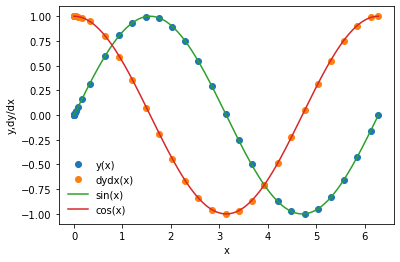

In [7]:
plt.plot(x,y[:,0],'o', label='y(x)')
plt.plot(x,y[:,1],'o', label='dydx(x)')
xx = np.linspace(0,2.0*np.pi,1000)
plt.plot(xx,np.sin(xx),label='sin(x)')
plt.plot(xx,np.cos(xx),label='cos(x)')
plt.xlabel('x')
plt.ylabel('y,dy/dx')
plt.legend(frameon=False)

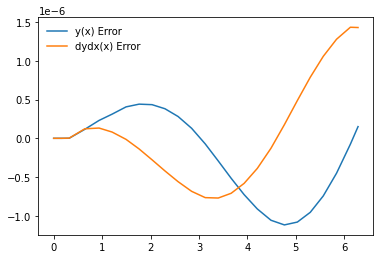

In [8]:
sine = np.sin(x)
cosine = np.cos(x)

y_error = (y[:,0]-sine)
dydx_error = (y[:,1]-cosine)

plt.plot(x,y_error, label="y(x) Error")
plt.plot(x,dydx_error, label="dydx(x) Error")
plt.legend(frameon=False)